# Import

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Spelling correction
import textblob
from textblob import TextBlob

# Text manipulation
import regex as re

# Lemmatization and tokenization
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Spacy
import spacy
nlp=spacy.load('en_core_web_sm')

# Creating vecotorization
from collections import Counter

# Inflect
import inflect
inflect = inflect.engine()

# Sentiment analysis with vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Wordcloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS

# Topic modeling
import gensim

# Loughran-McDonald sentiment word lists
from sklearn.feature_extraction.text import CountVectorizer

# Handling datetime
from pandas import to_datetime

# Plotting
import seaborn as sns


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('./Data/news_data_3.csv')
df.head(2).style

,URL,datetime,heading,text,newssite
0,https://www.scmp.com/news/hong-kong/health-environment/article/3196394/first-stage-ban-hong-kong-ban-single-use-plastics-be-brought-forward-two-years-2023-government-says,2022-10-18 12:00:00+00:00,"First stage of ban Hong Kong ban on single use plastics to be brought forward two years to 2023, government says","Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery, straws and plates Sale or free distribution of other plastics, such as hotel toiletries, umbrella covers and toothbrushes, also to be banned",South China Morning Post
1,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196374/coronavirus-legal-aid-granted-ex-civil-servant-challenging-hong-kongs-plan-invalidate-20000,2022-10-18 09:08:00+00:00,"Coronavirus: legal aid granted to ex civil servant challenging Hong Kong's plan to invalidate 20,000 'questionable' jab exemptions",High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department's refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use,South China Morning Post


In [3]:
# Delete rows with missing datetime
df = df.dropna()

# Convert column datetime to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
df['year'] = df['datetime'].dt.year.astype('category')
df['weekday']=df['datetime'].dt.weekday.astype('category')
df['month'] = df['datetime'].dt.month.astype('category')
df['date'] = df['datetime'].dt.date.astype('category')


# Data preparation

## 1. Spelling correction

In [4]:
def correct_spelling(text):
    
    # correct any spelling mistakes
    # assumption: spelling mistakes neglactable in news paper
    # TextBlob.correct() leads to weird results, e.g Hong Kong --> Long Long
    # text = str(TextBlob(text).correct())
 
    # write words out
    text = re.sub(r"’", "'", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'t", " not ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'m", " am ", text)
    
    return text

df['processed_text'] = df['text'].apply(lambda x: correct_spelling(x))

## 2. Remove special characters

In [5]:
def remove_special_characters_and_parts(text):

    #replace all words that just contain one letter
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', str(text)).strip()

    #remove most puntuation
    text = re.sub('([()‘’“”…+\-\{\}])+', ' ', text)
    text = re.sub(r"\\'+",' ', text)
    text = re.sub(r'\\"+',' ', text)
    text = re.sub(r'\\^+',' ', text)
    text = re.sub(r'\.+',' ', text)
    text = re.sub(r'\;+',' ', text)
    text = re.sub(r'\!+',' ', text)
    text = re.sub(r'\,+',' ', text)
    text = re.sub(r'\?+',' ', text)
    text = re.sub(r'\'+',' ', text)
    text = re.sub(r'\"+',' ', text)
    text = re.sub(r'\'+',' ', text)
    
    #remove slashes
    text = re.sub('\n', ' ', text)
    text = re.sub(r'[\\(/)]',' ', text)
    text = re.sub(r'[\\(\)]',' ', text)

    #get rid of and as a sign
    text = re.sub(r'\&',' and ', text)

    #remove unnecessary whitespaces
    text = re.sub(r'\s+', ' ', text)

    return text

df['processed_text'] = df['processed_text'].apply(lambda x: remove_special_characters_and_parts(x))

In [6]:
df.head(3).style

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text
0,https://www.scmp.com/news/hong-kong/health-environment/article/3196394/first-stage-ban-hong-kong-ban-single-use-plastics-be-brought-forward-two-years-2023-government-says,2022-10-18 12:00:00+00:00,"First stage of ban Hong Kong ban on single use plastics to be brought forward two years to 2023, government says","Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery, straws and plates Sale or free distribution of other plastics, such as hotel toiletries, umbrella covers and toothbrushes, also to be banned",South China Morning Post,2022,1,10,2022-10-18,Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery straws and plates Sale or free distribution of other plastics such as hotel toiletries umbrella covers and toothbrushes also to be banned
1,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196374/coronavirus-legal-aid-granted-ex-civil-servant-challenging-hong-kongs-plan-invalidate-20000,2022-10-18 09:08:00+00:00,"Coronavirus: legal aid granted to ex civil servant challenging Hong Kong's plan to invalidate 20,000 'questionable' jab exemptions",High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department's refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use,South China Morning Post,2022,1,10,2022-10-18,High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department is refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use
2,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196346/customs-seizes-crystal-meth-hk340-million-street-value-australia-concealed-electric-transformers,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden in Sydney bound electrical transformers worth HK$334 million at destination,Consignment containing 76kg of meth was in transit in city and scheduled to be delivered by air to Sydney Customs finds three wooden boxes carrying transformers weighing 300kg each,South China Morning Post,2022,1,10,2022-10-18,Consignment containing 76kg of meth was in transit in city and scheduled to be delivered by air to Sydney Customs finds three wooden boxes carrying transformers weighing 300kg each


## 3. Tokenization and Lemmatization

In [7]:
def normalize_text(text):
    tokenized_text = nlp(str(text).lstrip().rstrip())
    text = ""

    for token in tokenized_text:
        
          if (token.tag_ == "NN" or token.tag_ == "NE"):
            # Check if the noun is already singular
            if inflect.singular_noun(str(token)) == False:
                text+=" "+str(token).lower()
            else:  

                # Step 2
                # singularize a plural noun
                try:
                    singularized_text = inflect.plural(str(token).lower())
                    text+=" "+singularized_text.lower()

                except IndexError:
                    print(str(token))
                    text+=" "+str(token).lower()
                    pass   
          else:
            
            #filter out stopword based on part of speeach tagging
            # see https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/
            if (token.pos_ == "DET" or token.pos_ == "ADP" or 
                token.pos_ == "ADP" or token.pos_ == "CONJ" or
                token.pos_ == "PRON"):
                pass
                
            else:
            
                #lemmatization sometimes leads to bad results as result
                #we make a check for common letter which should be at least the length of the original string -1
                #else we are not doing the lemmatization
                common_letters = Counter(str(token).lower()) & Counter(str(token.lemma_).lower())

                if sum(common_letters.values()) >= len(str(token))-1:
                    text+=" "+str(token.lemma_).lower()
                else:
                    text+=" "+str(token).lower()

    return text

df['processed_text'] = df['processed_text'].apply(lambda x: normalize_text(x))

In [8]:
df.head(3).style

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text
0,https://www.scmp.com/news/hong-kong/health-environment/article/3196394/first-stage-ban-hong-kong-ban-single-use-plastics-be-brought-forward-two-years-2023-government-says,2022-10-18 12:00:00+00:00,"First stage of ban Hong Kong ban on single use plastics to be brought forward two years to 2023, government says","Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery, straws and plates Sale or free distribution of other plastics, such as hotel toiletries, umbrella covers and toothbrushes, also to be banned",South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non plastic alternative disposable item such cutlery straw and plate sale or free distribution other plastic such hotel toiletries umbrella cover and toothbrushes also to be banned
1,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196374/coronavirus-legal-aid-granted-ex-civil-servant-challenging-hong-kongs-plan-invalidate-20000,2022-10-18 09:08:00+00:00,"Coronavirus: legal aid granted to ex civil servant challenging Hong Kong's plan to invalidate 20,000 'questionable' jab exemptions",High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department's refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin win appeal legal aid department is refusal to provide financial backing judicial review certificates to remain effective until court determine if health authorities have power to overturn use
2,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196346/customs-seizes-crystal-meth-hk340-million-street-value-australia-concealed-electric-transformers,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden in Sydney bound electrical transformers worth HK$334 million at destination,Consignment containing 76kg of meth was in transit in city and scheduled to be delivered by air to Sydney Customs finds three wooden boxes carrying transformers weighing 300kg each,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transit city and schedule to be delivered air sydney customs find three wooden boxes carrying transformer weighing 300 kg


## 4. Remove additional stopwords

"I decided to go here for a list that does not remove much words the standard NLTK or Spacy stop word list
Spacys or NLTK Stopword list for example would remove words that are actually important - as I found out later.
And therefore would rahter lead to more issues instead of giving meaningful help"

In [9]:
# custom stoplist
customized_stopwords = ["and", "or", "either", "to", 
                        "such", "sure", "so", "also", "usually", "just",
                        "but", "however", "additionally", "furthermore", "while", "besides",
                        "are", "is", "be", "will", "make", "am", "has", "may", "might", "would", "can", "should",
                        "allow", "make", "use"]

def remove_stop_words(text):
    tokenized_text = str(text).split(" ")
    new_text = ""
    
    for token in tokenized_text:
        # Check if the word is in NLTKs stopword list
        if token in customized_stopwords:
              pass
        else:             
            new_text += " " + str(token)
    
    if len(new_text) > 5:
        return new_text
    else:
        return text

df['processed_text'] = df['processed_text'].apply(lambda x: remove_stop_words(x))

In [10]:
df.to_parquet('Preprocessed_dataset_V2') 

# Sentiment Analysis 

In [11]:
df = pd.read_parquet('Preprocessed_dataset_V2')

## Sentiment Analysis using TextBlob

In [12]:
def polarity_TextBlob(text):
    return TextBlob(text).sentiment.polarity

df['polarity_score_TextBlob']=df['processed_text'].apply(lambda x : polarity_TextBlob(x))

In [13]:
df.head(3).style

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,polarity_score_TextBlob
0,https://www.scmp.com/news/hong-kong/health-environment/article/3196394/first-stage-ban-hong-kong-ban-single-use-plastics-be-brought-forward-two-years-2023-government-says,2022-10-18 12:00:00+00:00,"First stage of ban Hong Kong ban on single use plastics to be brought forward two years to 2023, government says","Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery, straws and plates Sale or free distribution of other plastics, such as hotel toiletries, umbrella covers and toothbrushes, also to be banned",South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non plastic alternative disposable item cutlery straw plate sale free distribution other plastic hotel toiletries umbrella cover toothbrushes banned,0.137500
1,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196374/coronavirus-legal-aid-granted-ex-civil-servant-challenging-hong-kongs-plan-invalidate-20000,2022-10-18 09:08:00+00:00,"Coronavirus: legal aid granted to ex civil servant challenging Hong Kong's plan to invalidate 20,000 'questionable' jab exemptions",High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department's refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin win appeal legal aid department refusal provide financial backing judicial review certificates remain effective until court determine if health authorities have power overturn,0.352000
2,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196346/customs-seizes-crystal-meth-hk340-million-street-value-australia-concealed-electric-transformers,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden in Sydney bound electrical transformers worth HK$334 million at destination,Consignment containing 76kg of meth was in transit in city and scheduled to be delivered by air to Sydney Customs finds three wooden boxes carrying transformers weighing 300kg each,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transit city schedule delivered air sydney customs find three wooden boxes carrying transformer weighing 300 kg,0.000000


In [14]:
def sentiment_results(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
df['polarity_TextBlob']=df['polarity_score_TextBlob'].map(lambda x: sentiment_results(x))


In [15]:
df.head(3).style

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,polarity_score_TextBlob,polarity_TextBlob
0,https://www.scmp.com/news/hong-kong/health-environment/article/3196394/first-stage-ban-hong-kong-ban-single-use-plastics-be-brought-forward-two-years-2023-government-says,2022-10-18 12:00:00+00:00,"First stage of ban Hong Kong ban on single use plastics to be brought forward two years to 2023, government says","Plan changed because of increased acceptance of non plastic alternatives for disposable items such as cutlery, straws and plates Sale or free distribution of other plastics, such as hotel toiletries, umbrella covers and toothbrushes, also to be banned",South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non plastic alternative disposable item cutlery straw plate sale free distribution other plastic hotel toiletries umbrella cover toothbrushes banned,0.137500,positive
1,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196374/coronavirus-legal-aid-granted-ex-civil-servant-challenging-hong-kongs-plan-invalidate-20000,2022-10-18 09:08:00+00:00,"Coronavirus: legal aid granted to ex civil servant challenging Hong Kong's plan to invalidate 20,000 'questionable' jab exemptions",High profile serial litigant Kwok Cheuk kin wins appeal against Legal Aid Department's refusal to provide financial backing for judicial review Certificates to remain effective until court determines if health authorities have power to overturn their use,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin win appeal legal aid department refusal provide financial backing judicial review certificates remain effective until court determine if health authorities have power overturn,0.352000,positive
2,https://www.scmp.com/news/hong-kong/law-and-crime/article/3196346/customs-seizes-crystal-meth-hk340-million-street-value-australia-concealed-electric-transformers,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden in Sydney bound electrical transformers worth HK$334 million at destination,Consignment containing 76kg of meth was in transit in city and scheduled to be delivered by air to Sydney Customs finds three wooden boxes carrying transformers weighing 300kg each,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transit city schedule delivered air sydney customs find three wooden boxes carrying transformer weighing 300 kg,0.000000,neutral


## Sentiment analysis using VADER

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
works better in detecting negative sentiment

In [16]:
sid = SentimentIntensityAnalyzer()

def polarity_vader(text):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(text)
    return np.argmax(list(ss.values())[:-1])
df['polarity_score_vader'] = df['processed_text'].map(lambda x: polarity_vader(x))
df['polarity_vader']=df['polarity_score_vader'].replace({0:'negative',1:'neutral',2:'positive'})

In [17]:
df.head(3)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,polarity_score_TextBlob,polarity_TextBlob,polarity_score_vader,polarity_vader
0,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 12:00:00+00:00,First stage of ban Hong Kong ban on single us...,Plan changed because of increased acceptance ...,South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non ...,0.1375,positive,1,neutral
1,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 09:08:00+00:00,Coronavirus: legal aid granted to ex civil se...,High profile serial litigant Kwok Cheuk kin w...,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin ...,0.3520,positive,1,neutral
2,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden i...,Consignment containing 76kg of meth was in tr...,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transi...,0.0000,neutral,1,neutral


## Sentiment analysis using Loughran-McDonald sentiment word lists

Wordlist specifically built for textual analysis related finance (https://sraf.nd.edu/loughranmcdonald-master-dictionary/)

In [18]:
# source: https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92#:~:text=Machine%20learning%20models%20implemented%20in,forms%20to%20forecast%20stock%20movements
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining']

sentiment_df = pd.read_csv('./Data/Loughran-McDonald_MasterDictionary_1993-2021.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

def lemmatize_words(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    return lemmatized_words

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,word
9,True,False,False,False,False,abandon
12,True,False,False,False,False,abandonment
13,True,False,False,False,False,abandonments
51,True,False,False,False,False,abdicate
54,True,False,False,False,False,abdication


#### Jaccard Similarity

Count how many negative/positive/.... words occur in the document and jaccard similarity to determine how similar the bag of words in the newspaper and the bag of words of the respecitive sentiment are.

In [19]:
def count_sentiments(sent_words_filtered, text_list):
    vec = CountVectorizer(vocabulary=sent_words_filtered)
    vectors = vec.fit_transform(text_list)
    sentiment_counts = np.zeros([len(text_list), len(vec.get_feature_names_out())])
    
    for i in range(len(text_list)):
        sentiment_counts[i] = vectors[i].toarray()[0]

    sum_word = sentiment_counts.astype(int).sum(axis=1)
      
    # Calculate jaccard similarity
    jac_sim = np.zeros([len(text_list)])
    for i in range(len(text_list)):
        jac_sim[i] = float(sum_word[i]) / ((len(sent_words_filtered) + len(text_list[i].split())) - float(sum_word[i]) )

    return jac_sim, sum_word


for sentiment in sentiments:
    df[sentiment + '_jacsim'], df[sentiment + '_count'] = count_sentiments(sentiment_df.loc[sentiment_df[sentiment] == True]['word'], df['processed_text'].tolist() )

In [20]:
df.head(6)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,...,negative_jacsim,negative_count,positive_jacsim,positive_count,uncertainty_jacsim,uncertainty_count,litigious_jacsim,litigious_count,constraining_jacsim,constraining_count
0,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 12:00:00+00:00,First stage of ban Hong Kong ban on single us...,Plan changed because of increased acceptance ...,South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non ...,...,0.000000,0,0.00000,0,0.0,0,0.000000,0,0.0,0
1,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 09:08:00+00:00,Coronavirus: legal aid granted to ex civil se...,High profile serial litigant Kwok Cheuk kin w...,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin ...,...,0.001942,3,0.00722,2,0.0,0,0.006729,5,0.0,0
2,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden i...,Consignment containing 76kg of meth was in tr...,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transi...,...,0.000000,0,0.00000,0,0.0,0,0.000000,0,0.0,0
3,https://www.scmp.com/news/hong-kong/politics/a...,2022-10-18 05:59:00+00:00,Hong Kong will need more time on Article 23 r...,The local legislation cannot be rushed as it ...,South China Morning Post,2022,1,10,2022-10-18,local legislation not rushed as have cover s...,...,0.000000,0,0.00000,0,0.0,0,0.001335,1,0.0,0
4,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 04:25:00+00:00,Coronavirus: Hong Kong 'set to ease cap on pu...,Sources say top advisers approved move at Tue...,South China Morning Post,2022,1,10,2022-10-18,source say top adviser approve move tuesday ...,...,0.000647,1,0.00000,0,0.0,0,0.000000,0,0.0,0
6,https://www.scmp.com/news/hong-kong/hong-kong-...,2022-09-11 03:00:00+00:00,Hong Kong has extended its Covid 19 vaccine p...,New scheme comes into force on Friday with fi...,South China Morning Post,2022,6,9,2022-09-11,new scheme come force friday first phase req...,...,0.000647,1,0.00000,0,0.0,0,0.000000,0,0.0,0


# Named entity recognition

In [21]:
def extract_company(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_=='ORG' else None
df['company']=df['processed_text'].apply(lambda x : extract_company(x))

def extract_country(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'GPE' else None
df['country']=df['processed_text'].apply(lambda x : extract_country(x))

def extract_date(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'DATE' else None        
df['date_event']=df['processed_text'].apply(lambda x : extract_date(x))

def extract_event(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'EVENT' else None   
       
df['event']=df['processed_text'].apply(lambda x : extract_event(x))


In [22]:
df.head(6)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,...,uncertainty_jacsim,uncertainty_count,litigious_jacsim,litigious_count,constraining_jacsim,constraining_count,company,country,date_event,event
0,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 12:00:00+00:00,First stage of ban Hong Kong ban on single us...,Plan changed because of increased acceptance ...,South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non ...,...,0.0,0,0.000000,0,0.0,0,None,None,None,None
1,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 09:08:00+00:00,Coronavirus: legal aid granted to ex civil se...,High profile serial litigant Kwok Cheuk kin w...,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin ...,...,0.0,0,0.006729,5,0.0,0,None,None,None,None
2,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden i...,Consignment containing 76kg of meth was in tr...,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transi...,...,0.0,0,0.000000,0,0.0,0,None,None,None,None
3,https://www.scmp.com/news/hong-kong/politics/a...,2022-10-18 05:59:00+00:00,Hong Kong will need more time on Article 23 r...,The local legislation cannot be rushed as it ...,South China Morning Post,2022,1,10,2022-10-18,local legislation not rushed as have cover s...,...,0.0,0,0.001335,1,0.0,0,None,None,None,None
4,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 04:25:00+00:00,Coronavirus: Hong Kong 'set to ease cap on pu...,Sources say top advisers approved move at Tue...,South China Morning Post,2022,1,10,2022-10-18,source say top adviser approve move tuesday ...,...,0.0,0,0.000000,0,0.0,0,None,None,tuesday,None
6,https://www.scmp.com/news/hong-kong/hong-kong-...,2022-09-11 03:00:00+00:00,Hong Kong has extended its Covid 19 vaccine p...,New scheme comes into force on Friday with fi...,South China Morning Post,2022,6,9,2022-09-11,new scheme come force friday first phase req...,...,0.0,0,0.000000,0,0.0,0,None,None,None,None


In [23]:
df['company'].unique()

array([None, 'cathay', 'congress', 'intensifie', 'hui', 'kin',
       'warner cheuk', 'eastern court magistrate', 'cnn'], dtype=object)

In [24]:
df['date_event'].unique()

array([None, 'tuesday', 'next month', 'early fourth quarter 2023',
       'monday', 'sunday', 'saturday', 'end year', '63 year old',
       'thursday', 'wednesday 4 420', 'wednesday', '61 year old',
       '87 year old', '26 year old', 'fourth quarter 2024'], dtype=object)

In [25]:
df['country'].unique()

array([None, 'hong kong', 'singapore', 'hong kong council', 'japan',
       'taiwan'], dtype=object)

# Create Wordcloud

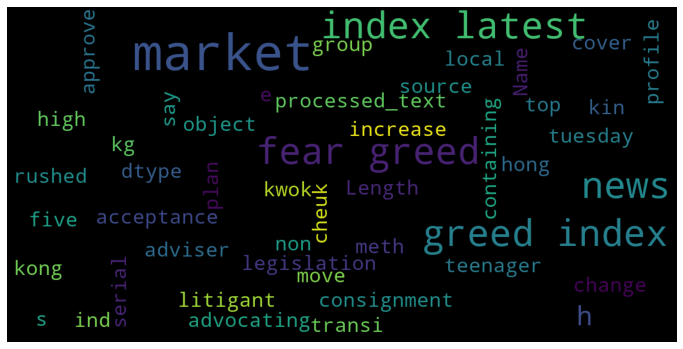

In [26]:
# source: https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/4-0-wordclouds-853dfded-4d17-4f37-83e4-15ec53f74e60/5833b046-3cf9-4c0f-8fbf-4a5933da924e

def plot_wordcloud(text):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=30, 
        scale=3,
        random_state=1).generate(text)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

    
plot_wordcloud(str(df['processed_text']))

# Topic modeling exploration with pyLDAvis

In [27]:
# Prepare data for applying the model (create corpus)
# sources: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
#+ https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.processed_text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])


['plan', 'change', 'because', 'increase', 'acceptance', 'non', 'plastic', 'alternative', 'disposable', 'item', 'cutlery', 'straw', 'plate', 'sale', 'free', 'distribution', 'other', 'plastic', 'hotel', 'toiletries', 'umbrella', 'cover', 'toothbrushes', 'banned']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


In [28]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"have" + 0.008*"hong" + 0.008*"said" + 0.008*"kong" + 0.006*"that" + '
  '0.006*"not" + 0.005*"were" + 0.005*"covid" + 0.005*"new" + 0.005*"was"'),
 (1,
  '0.012*"have" + 0.012*"hong" + 0.010*"was" + 0.009*"kong" + 0.008*"said" + '
  '0.007*"that" + 0.005*"covid" + 0.005*"not" + 0.004*"year" + 0.004*"as"'),
 (2,
  '0.013*"have" + 0.011*"hong" + 0.010*"kong" + 0.009*"was" + 0.009*"said" + '
  '0.008*"that" + 0.006*"were" + 0.005*"not" + 0.005*"as" + 0.004*"year"'),
 (3,
  '0.014*"have" + 0.011*"said" + 0.008*"was" + 0.008*"covid" + 0.007*"not" + '
  '0.007*"kong" + 0.007*"that" + 0.006*"case" + 0.006*"hong" + 0.006*"hk"'),
 (4,
  '0.017*"kong" + 0.017*"said" + 0.016*"have" + 0.014*"hong" + 0.010*"that" + '
  '0.009*"was" + 0.007*"not" + 0.006*"as" + 0.005*"covid" + 0.005*"year"'),
 (5,
  '0.010*"have" + 0.010*"said" + 0.010*"was" + 0.009*"kong" + 0.008*"hong" + '
  '0.005*"that" + 0.005*"not" + 0.004*"were" + 0.004*"covid" + 0.004*"as"'),
 (6,
  '0.013*"said" + 0.012*"that

In [29]:
# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

C:\Users\Jenny\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.002634  0.018563       1        1  29.590670
7     -0.028115  0.027990       2        1  24.670498
9     -0.001455  0.013687       3        1  13.123355
2     -0.003875 -0.005396       4        1   9.468548
3      0.032661  0.002050       5        1   7.261950
8     -0.024684 -0.026390       6        1   5.566083
6      0.012836  0.005124       7        1   3.764543
5     -0.006565 -0.016282       8        1   3.030869
0      0.009447 -0.007008       9        1   2.016779
1      0.007116 -0.012337      10        1   1.506707, topic_info=           Term        Freq       Total Category  logprob  loglift
34         have  414.000000  414.000000  Default  30.0000  30.0000
156        hong  416.000000  416.000000  Default  29.0000  29.0000
380        said  384.000000  384.000000  Default  28.0000  28.0000
69          was  243.000000  243.000000  Default  27.0000  27.0000
306        that  277.000000  277.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
188  government    1.239795  109.658062  Topic10  -5.8431  -0.2872
464        been    1.066345   78.557255  Topic10  -5.9938  -0.1043
716     support    0.964458   55.490952  Topic10  -6.0942   0.1428
934      policy    0.979399   73.018221  Topic10  -6.0788  -0.1163
139         one    0.943748   66.603205  Topic10  -6.1159  -0.0614

[780 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
269       6  0.700961  accounting
451       1  0.247867       added
451       2  0.272654       added
451       3  0.198294       added
451       4  0.099147       added
...     ...       ...         ...
323       7  0.035272        year
323       8  0.026454        year
323       9  0.008818        year
323      10  0.017636        year
5007      1  0.353561        yuan

[1812 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 10, 3, 4, 9, 7, 6, 1, 2])

In [30]:
df.to_parquet('sentimentAnalysis_dataframe') 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 127
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   URL                      125 non-null    object             
 1   datetime                 125 non-null    datetime64[ns, UTC]
 2   heading                  125 non-null    object             
 3   text                     125 non-null    object             
 4   newssite                 125 non-null    object             
 5   year                     125 non-null    int64              
 6   weekday                  125 non-null    int64              
 7   month                    125 non-null    int64              
 8   date                     125 non-null    object             
 9   processed_text           125 non-null    object             
 10  polarity_score_TextBlob  125 non-null    float64            
 11  polarity_TextBlob        125 non